<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None
          instant      season          yr        mnth     holiday     weekday  \
count  

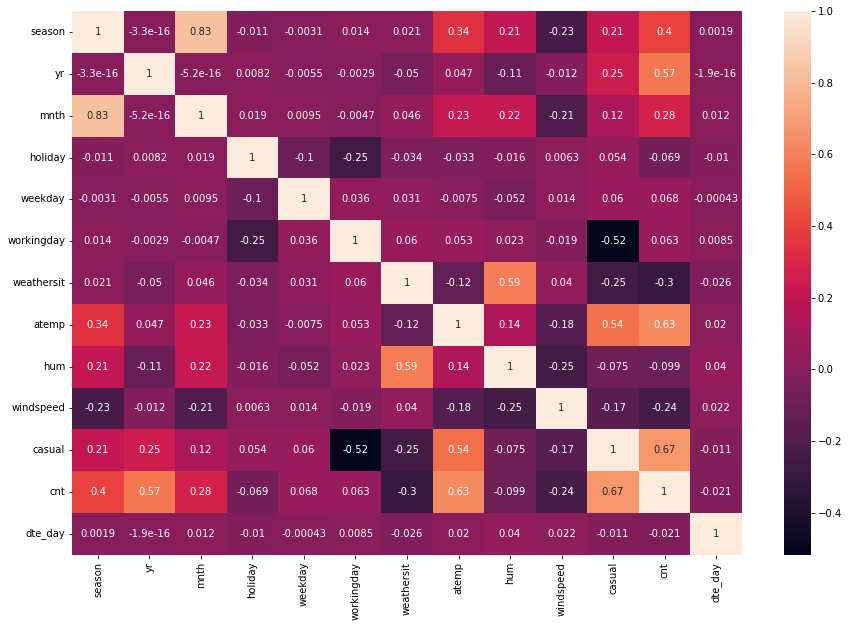

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import scipy
from scipy import stats

from statsmodels.stats.stattools import durbin_watson

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

boom= pd.read_csv("./day.csv")
print(boom.info())
print(boom.describe())

# Fall is the season when maximum bikes are rented. 

# Cleaning and handling data type
boom = boom.drop(boom.columns[boom.isna().all()].tolist(),axis=1)
boom['dte_year'] = (boom.dteday.apply(lambda x: str(x)[-4:]))
boom.dte_year = boom.dte_year.astype('int32')
boom['dte_month'] = (boom.dteday.apply(lambda x:str(x)[-7:-5]))
boom.dte_month = boom.dte_month.astype('int32')
boom['dte_day'] = (boom.dteday.apply(lambda x:str(x)[:2]))
boom.dte_day = boom.dte_day.astype('int32')
# dropping the original column
boom = boom.drop(['dteday'],axis=1)

# dropping highly correlated elements
# dropping temp as it is highly co-related with atemp. Retaining atemp as it is the feeling temperature
# dropping registered is highly co-related with cnt
# dropping instant as it is only an id column
# dropping dte_year as it is highly correlated to yr
# dropping dte_month as it is highly correlated to mnth
boom = boom.drop(['temp','registered','instant','dte_year','dte_month'],axis=1)

plt.figure(figsize=(15, 10))
sns.heatmap(boom.corr(),annot=True)

boom=pd.get_dummies(boom, drop_first=True)
boom['spring']=boom['season'].apply(lambda x:1 if(x==1) else 0)
boom['summer']=boom['season'].apply(lambda x:1 if(x==2) else 0)
boom['fall']=boom['season'].apply(lambda x:1 if(x==3) else 0)

boom['Clear']=boom['weathersit'].apply(lambda x:1 if(x==1) else 0)
boom['Mist']=boom['weathersit'].apply(lambda x:1 if(x==2) else 0)
boom['Snow']=boom['weathersit'].apply(lambda x:1 if(x==3) else 0)

boom = boom.drop(['weekday','dte_day','season','weathersit'],axis=1)

print(boom.info())

In [10]:
from sklearn.metrics import r2_score

def calculateVIF(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
    print(vif_data)

def getLinearModel(y_tr,X_tr):
    X_tr= sm.add_constant(X_tr)
    lr = sm.OLS(y_tr,X_tr)
    model=lr.fit()    
    return model,X_tr
    
def splitTrainTest(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)
    return X_train, X_test, y_train, y_test

def minMaxScaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    scaler.transform(df)
    return df,scaler

def print_score(y_test,y_test_pred):
    print('R2 score '+ str(r2_score(y_true=y_test,y_pred=y_test_pred)))
    print('MSE '+ str(mean_squared_error(y_test, y_test_pred)))
    print('RMSE '+ str(math.sqrt(mean_squared_error(y_test, y_test_pred))))
    
    res = scipy.stats.pearsonr(y_test, y_test_pred)
    print('Pearson r'+ str(res))
    
def predictY(lm,X_test,y_test):
    X_test = sm.add_constant(X_test)
    y_test_pred=lm.predict(X_test)
    fig = plt.figure()
    return y_test_pred
     
def evaluateLinearRegression(res):
    sns.set(style="whitegrid")    
    fig = sm.qqplot(res, stats.t, distargs=(4,))
    plt.show()
    
def residualFitPlot(X_test,y_test,y_test_pred):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize =(5,5))
    sns.regplot(x=y_test_pred,y=y_test-y_test_pred,ax=ax,lowess=True)
    ax.set(ylabel='residuals',xlabel='fitted values')

def errorTerms(y_,y_pred):
    fig=plt.figure()    
    sns.distplot(y_-y_pred,bins=20)
    fig.suptitle('Error Terms',fontsize=20)
    plt.xlabel('Errors',fontsize=10)

def linearRegression(X_,y_):
    lm=LinearRegression()
    lm.fit(X_,y_)
    return lm

In [11]:
def buildModel(df,cols):
    plt.figure(figsize=(25, 25))
    sns.heatmap(df.corr(),annot=True)
    
    y=df.pop('cnt')
    X=df

    # Split train test
    X_tr, X_tst, y_trn, y_tst=splitTrainTest(X,y)
    
    # Scaling elements
    X_tr,scaler = minMaxScaler(X_tr)
    
    X_trn_new = X_tr[cols]
    
    calculateVIF(X_trn_new)
    return scaler,X_trn_new, X_tst, y_trn, y_tst

def evaluateModel(scaler,X_trn_new, X_tst, y_trn, y_tst):    
    lm,X_trn_new=getLinearModel(y_trn,X_trn_new)
    print(lm.summary())
    
    y_trn_pred=predictY(lm,X_trn_new,y_trn)
    errorTerms(y_trn,y_trn_pred)
    
    scaler.transform(X_tst)
    cols = list(X_trn_new)
    cols.remove('const')
    X_tst_new = X_tst[cols]

    #Predicting Y
    y_tst_pred=predictY(lm,X_tst_new,y_tst)
    #Residual vs Fit should be random
    residualFitPlot(X_tst_new,y_tst,y_tst_pred)
    evaluateLinearRegression(y_tst-y_tst_pred)
    #R2 score
    print_score(y_tst,y_tst_pred)
    return X_tst_new,y_tst_pred

  feature       VIF
0      yr  2.024275
1   atemp  3.375334
2  spring  1.217518
3   Clear  2.733053
4    Snow  1.060175
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     404.4
Date:                Wed, 10 Aug 2022   Prob (F-statistic):          5.80e-174
Time:                        20:35:31   Log-Likelihood:                -4185.2
No. Observations:                 511   AIC:                             8382.
Df Residuals:                     505   BIC:                             8408.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

/Users/soumyaswaroopgupta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


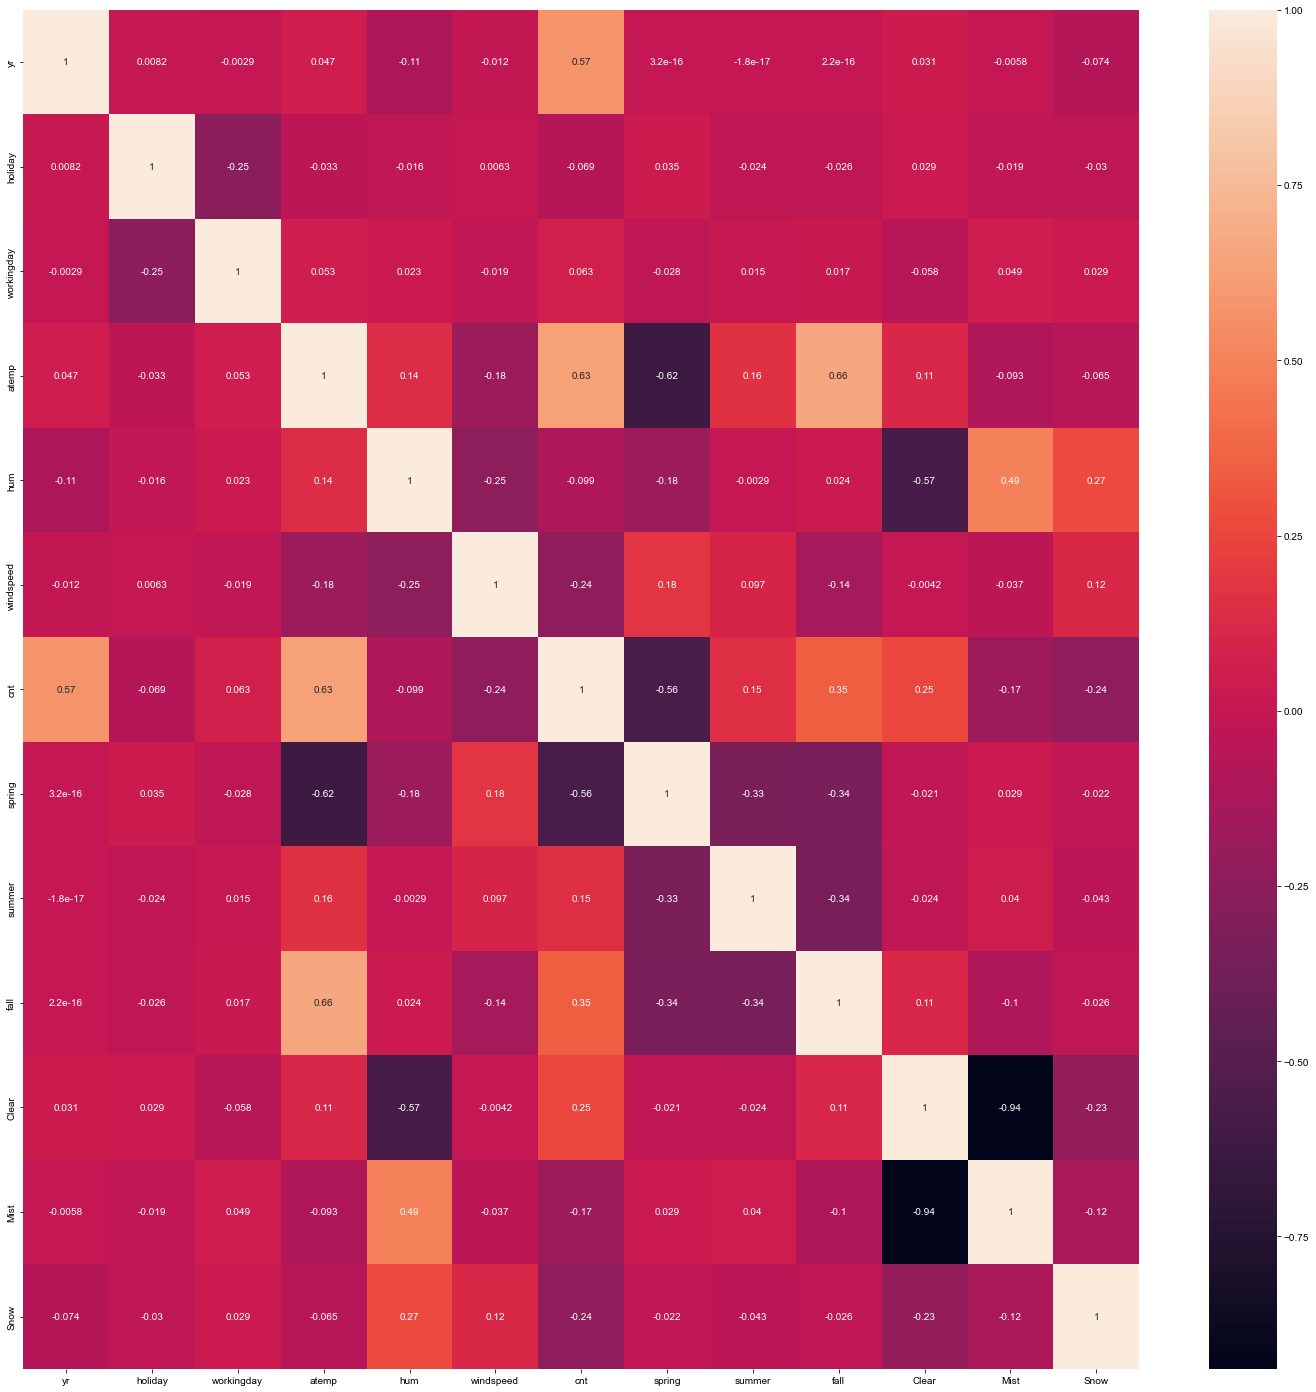

<Figure size 432x288 with 0 Axes>

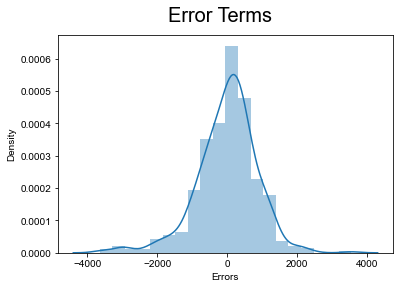

<Figure size 432x288 with 0 Axes>

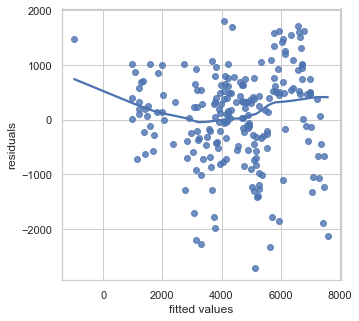

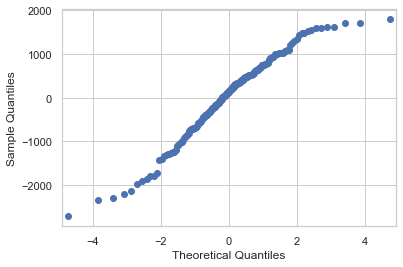

R2 score 0.7959996786475841
MSE 732024.4189196883
RMSE 855.5842558858177
Pearson r(0.8924870085524057, 5.6713423993918084e-77)


In [12]:
#BuildingModel1
boom_analysis = boom[boom.columns]
boom_analysis = boom_analysis.drop(['mnth','casual'],axis=1)
# Using incremental addition of columns
#start with the column with most correlation. That is casual. But this introduces strong multicollinearity. Hence not using it.
# Though spring is highly co-related we are not using it in the model as we are interested in the demand
# and thereby the positive co-effiecients.
cols = ['yr','atemp','spring','Clear','Snow']

scaler,X_train_1,X_test_1,y_train_1,y_test_1=buildModel(boom_analysis,cols)
X_tst_new,y_tst_pred=evaluateModel(scaler,X_train_1,X_test_1,y_train_1,y_test_1)

# The model has an R-squared of 0.800 and adjusted R-squared 0.798
# The VIF also has all parameters below 5 and the parameters have statistical significance P>|t|.
# AIC is 8382 and BIC is 8408
#evaluateModel(scaler, lm, X_train_new,y_train,X_test_new,y_test)



     feature       VIF
0      atemp  5.237998
1         yr  2.043737
2   janToMar  1.321402
3      Clear  2.635192
4  windspeed  4.542504
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     347.7
Date:                Wed, 10 Aug 2022   Prob (F-statistic):          6.19e-161
Time:                        20:35:55   Log-Likelihood:                -4215.6
No. Observations:                 511   AIC:                             8443.
Df Residuals:                     505   BIC:                             8469.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

/Users/soumyaswaroopgupta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


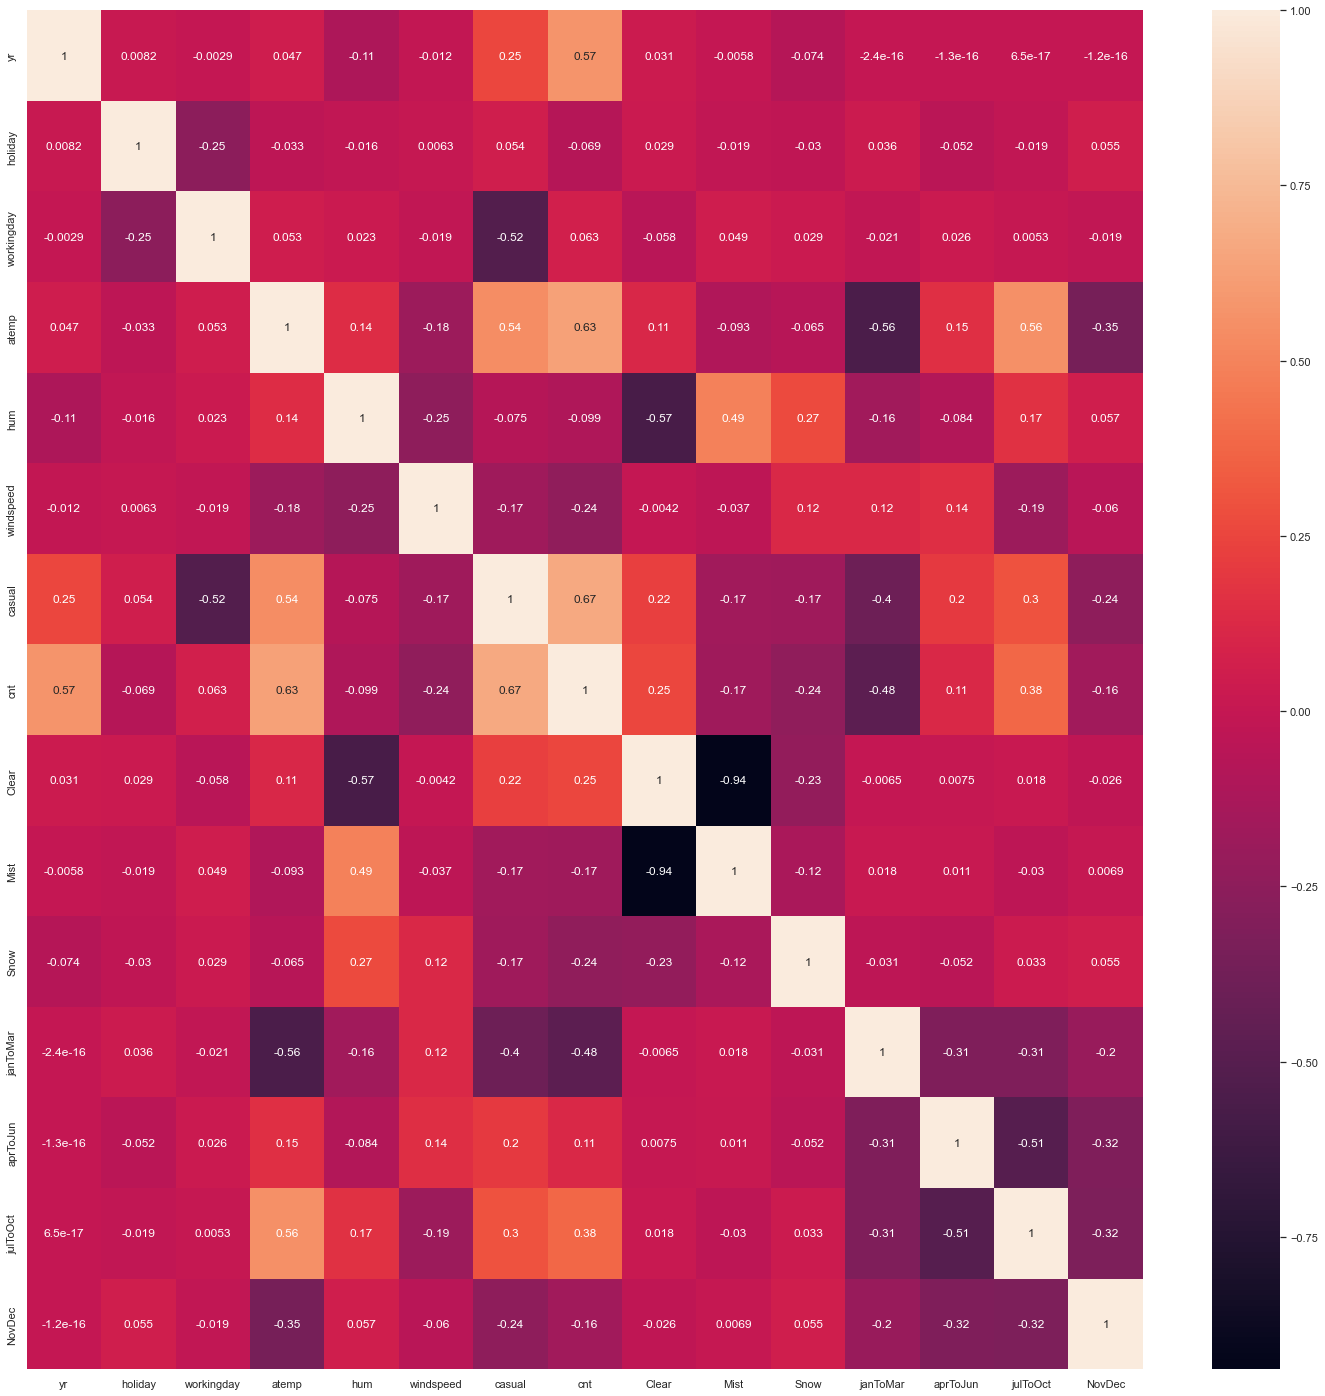

<Figure size 432x288 with 0 Axes>

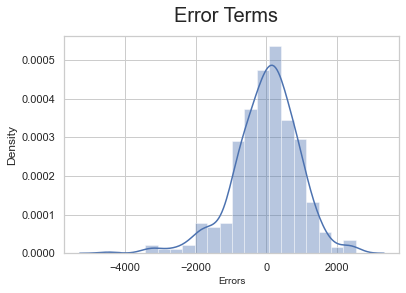

<Figure size 432x288 with 0 Axes>

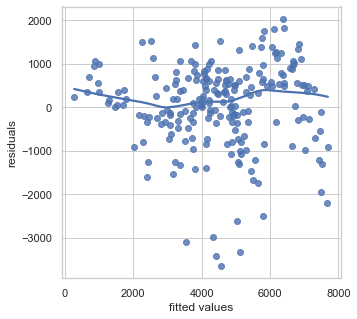

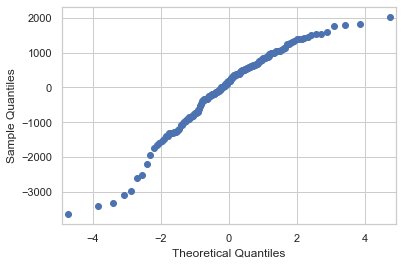

R2 score 0.7354013569150488
MSE 949472.3668429436
RMSE 974.4087267891969
Pearson r(0.8577705631118582, 1.213750756497015e-64)


(        atemp  yr  janToMar  Clear  windspeed
 184  33.27085   0         0      0   5.459106
 535  36.04875   1         0      1   7.625404
 299  22.85230   0         0      0  13.250121
 221  34.24915   0         0      1  13.417286
 152  32.19710   0         0      1  19.583229
 ..        ...  ..       ...    ...        ...
 400  13.22605   1         1      0  11.791732
 702  23.45270   1         0      1  11.666643
 127  25.94665   0         0      1   5.000712
 640  29.95665   1         0      0   4.458569
 72   16.60000   0         0      1   9.174042
 
 [219 rows x 5 columns],
 184    4523.675455
 535    7522.009831
 299    3058.871815
 221    4941.398209
 152    4411.944680
           ...     
 400    3086.546683
 702    6030.849228
 127    4534.961429
 640    6334.989435
 72     3367.367542
 Length: 219, dtype: float64)

In [13]:
#BuildingMode 2

boom_mnth = boom[boom.columns]

boom_mnth['janToMar']=boom_mnth.mnth.apply(lambda x:1 if(x==1 or x==2) else 0)
boom_mnth['aprToJun']=boom_mnth.mnth.apply(lambda x:1 if(x==3 or x==4 or x==5 or x==6) else 0)
boom_mnth['julToOct']=boom_mnth.mnth.apply(lambda x:1 if(x==7 or x==8 or x==9 or x==10) else 0)
boom_mnth['NovDec']=boom_mnth.mnth.apply(lambda x:1 if(x==12 or x==11) else 0)

boom_mnth = boom_mnth.drop(['mnth','fall','summer','spring'],axis=1)

#start with the column with most correlation. That is casual. But this introduces strong multicollinearity. Hence not using it.
# Though janToMar is highly co-related we are not using it in the model as we are interested in the demand
# and thereby the positive co-effiecients.
cols = ['atemp','yr','janToMar','Clear','windspeed']
#stopping here as the other parameters do not have significant correlation. 

scaler,X_train_2,y_train_2,X_test_2,y_test_2=buildModel(boom_mnth,cols)
evaluateModel(scaler,X_train_2,y_train_2,X_test_2,y_test_2)
# The model has an R-squared of 0.775 and adjusted R-squared 0.773
# The VIF also has all parameters below 5 and the parameters have statistical significance P>|t| less than 0.05.
# AIC is 8443 and BIC is 8469


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   atemp       730 non-null    float64
 4   hum         730 non-null    float64
 5   windspeed   730 non-null    float64
 6   casual      730 non-null    int64  
 7   cnt         730 non-null    int64  
 8   spring      730 non-null    int64  
 9   summer      730 non-null    int64  
 10  fall        730 non-null    int64  
 11  Clear       730 non-null    int64  
 12  Mist        730 non-null    int64  
 13  Snow        730 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 80.0 KB
None
[('yr', True, 1), ('holiday', False, 2), ('workingday', False, 6), ('atemp', False, 8), ('hum', False, 10), ('windspeed', False, 9), ('casual', False, 11), ('spring', True, 1), ('sum

/Users/soumyaswaroopgupta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


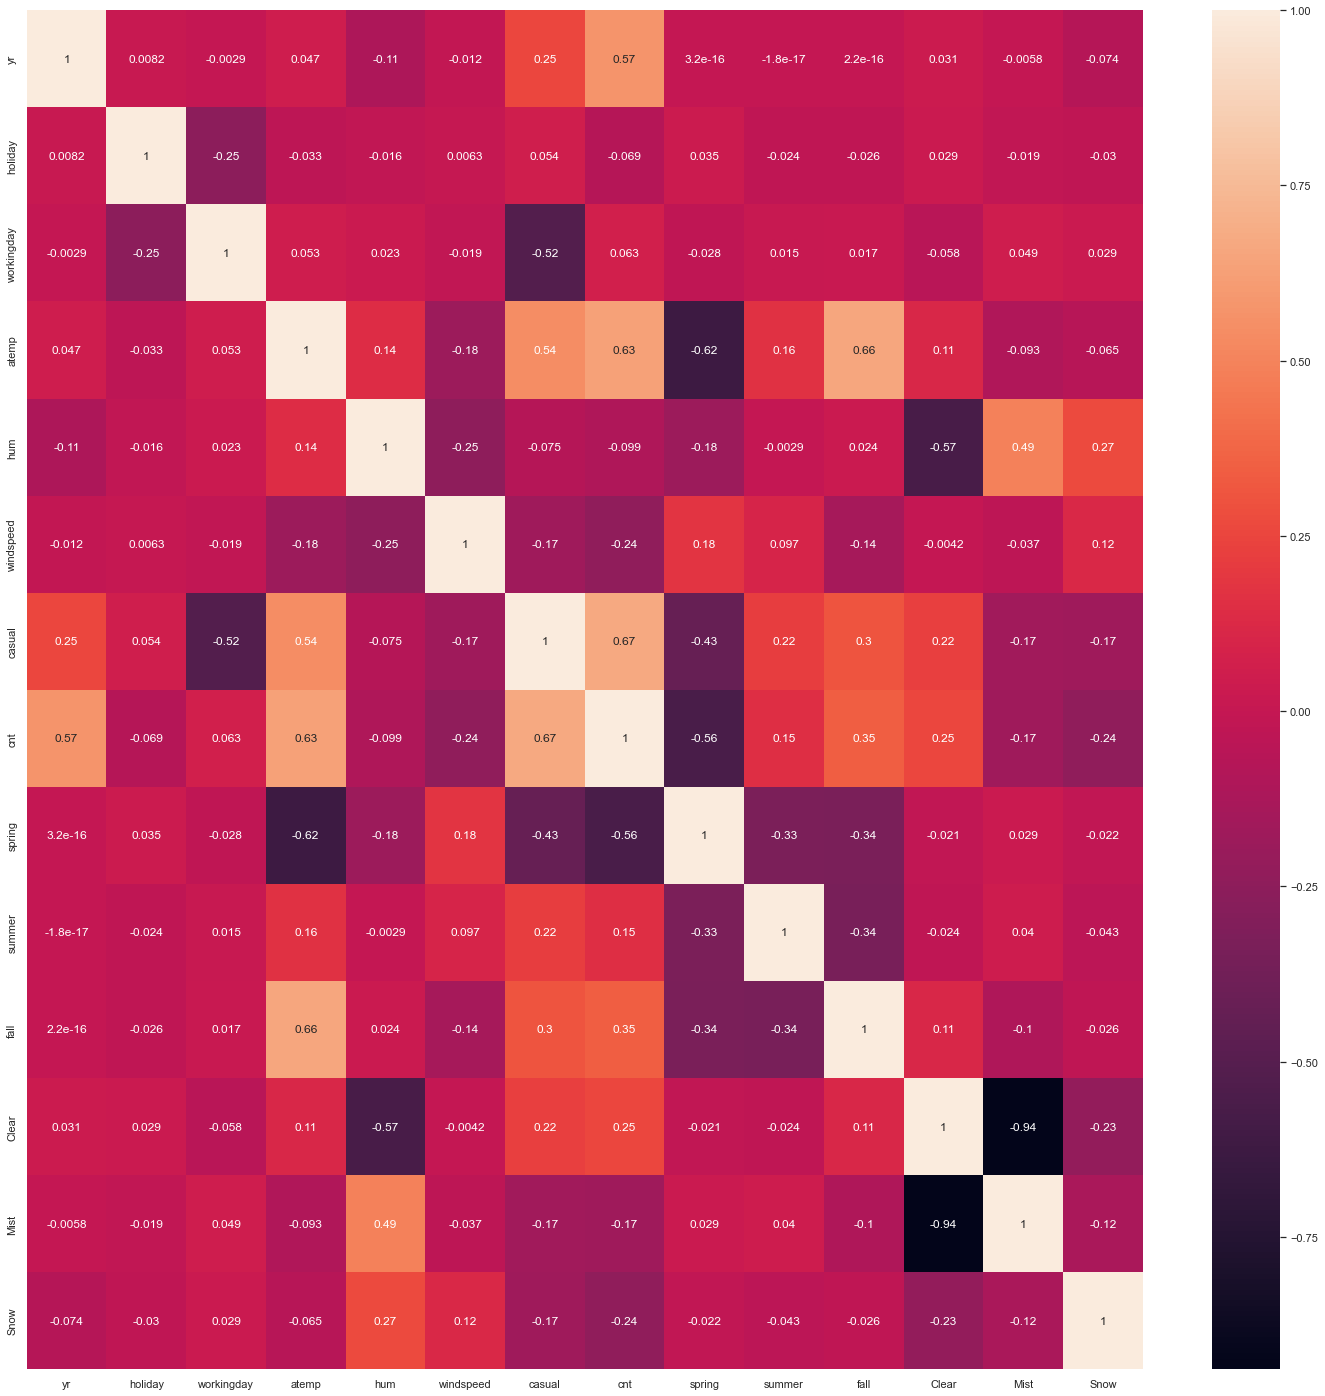

<Figure size 432x288 with 0 Axes>

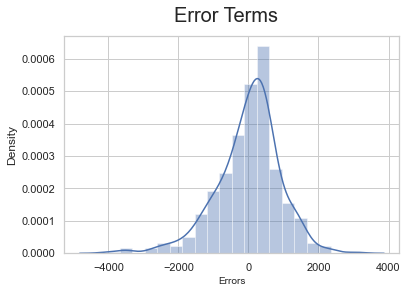

<Figure size 432x288 with 0 Axes>

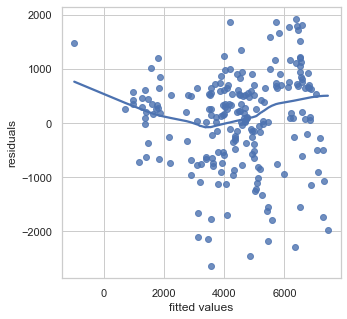

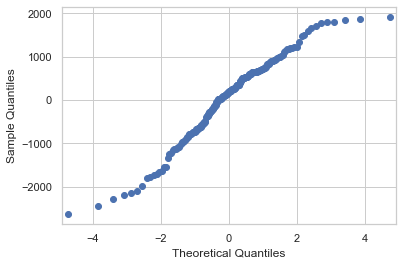

R2 score 0.783707883088013
MSE 776131.6754294985
RMSE 880.9833570672596
Pearson r(0.8861286590938569, 2.021278114788726e-74)


(     yr  holiday     atemp  spring  Snow
 184   0        1  33.27085       0     0
 535   1        0  36.04875       0     0
 299   0        0  22.85230       0     0
 221   0        0  34.24915       0     0
 152   0        0  32.19710       0     0
 ..   ..      ...       ...     ...   ...
 400   1        0  13.22605       1     0
 702   1        0  23.45270       0     0
 127   0        0  25.94665       0     0
 640   1        0  29.95665       0     0
 72    0        0  16.60000       1     0
 
 [219 rows x 5 columns],
 184    4179.714668
 535    7121.725960
 299    3782.017557
 221    4889.242607
 152    4689.882155
           ...     
 400    3585.299787
 702    5897.996413
 127    4082.639381
 640    6529.867181
 72     1855.436382
 Length: 219, dtype: float64)

In [14]:
#BuildingMode 3
boom_RFE = boom[boom.columns]

boom_RFE = boom_RFE.drop(['mnth'],axis=1)
print(boom_RFE.info())

backup = boom_RFE[boom_RFE.columns]
y_RFE=boom_RFE.pop('cnt')
X_RFE=boom_RFE
# Using RFE method to initially find the columns
lm=linearRegression(X_RFE,y_RFE)

rfe=RFE(estimator=lm,n_features_to_select=3)
rfe.fit(X_RFE,y_RFE)
print(list(zip(X_RFE.columns,rfe.support_,rfe.ranking_)))

# using hybrid approach to build model. Removing the parameters with negative co-efficient
X_model_3 = X_RFE[X_RFE.columns]
X_model_3 = X_model_3.drop(['casual','hum','windspeed','fall','workingday','Mist','summer','Clear'],axis=1)

# The model has an R-squared of 0.779 and adjusted R-squared 0.777
# The VIF also has all parameters below 5 and the parameters have statistical significance P>|t| less than 0.05.
# AIC is 8443 and BIC is 8459

columnList = X_model_3.columns.values
np.append(columnList,'cnt')
scaler_3,X_train_3,y_train_3,X_test_3,y_test_3=buildModel(backup,columnList)
evaluateModel(scaler_3,X_train_3,y_train_3,X_test_3,y_test_3)

# Comparing Models

* In all the models, the VIF also has all parameters below 5 and all the parameters have statistical significance P>|t| is less than 0.05
* None of the parameters' confidence interval contains 0
* All the model error terms are centered around 0 and have an approximately normal distribution. The errors are randomly scattered and centered around zero. So this can be considered as white noise.
* In all the models the r-squared and adjusted r-squared are close, so there are no irrelevant parameters and the model is good.
* The Model with the best(least) AIC and BIC is Model 1
* All the Durbin-Watson is within the range of 1.5 and 2.5, we consider it to have homoscedasticity, or an even distribution of errors throughout our data.

|Parameter    |Model 1 |Model 2  |Model 3  |
|-------------|--------|---------|---------|
|R-square     |0.800   |0.775    |0.779    |
|Ad-rsq       |0.798   |0.773    |0.777    |
|AIC          |8382    |8443     |8443     |
|BIC          |8408    |8469     |8459     |
|P(F-stats)   |5.8e-174|6.19e-161|4.37e-163|
|Durbin-Watson|2.024   |2.052    |1.983    |
|RMSE         |855.584 |974.408  |880.983  |
|R2-score     |0.7959  |0.735    |0.7837   |

# Going with model 1

Since model 1 has the best parameters, going with model 1

cnt = 92.7506*atemp +2053.8107*yr -1377.2461*spring+ 636.1012*Clear -1797.0367*Snow + 1255.3436
